#1. Training a convnet from scratch on a small dataset for image classification



## The relevance of DL for small-data problems

You sometimes hear that DL only works when lots of data is available. 

However, what constitutes "lots" of samples is relative. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can 
potentially suffice if the model is small and well-regularized and if the task is simple. 

## 1.1. The data: No data, no machine learning

The cats vs. dogs dataset was made available by Kaggle.com. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy, even though we will be training our 
models on less than 10% of the data that was available to the competitors.


In [0]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

import keras
keras.__version__

TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.


'2.3.1'

In [0]:
import os, shutil

from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!wget https://www.dropbox.com/s/i2rikoreagea5ky/dog-cat-small.zip?dl=0 \
    -O /content/drive/My\ Drive/dog-cat-small.zip


--2020-04-18 01:11:21--  https://www.dropbox.com/s/i2rikoreagea5ky/dog-cat-small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/i2rikoreagea5ky/dog-cat-small.zip [following]
--2020-04-18 01:11:22--  https://www.dropbox.com/s/raw/i2rikoreagea5ky/dog-cat-small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb95522941b6c5e2ce21192dba.dl.dropboxusercontent.com/cd/0/inline/A2DhJMoBepwUU1uCfSuqdXLgbNKts9uTHRrvN8Z9SZbaVWz0vASghfzPoDCLIXMh6PfzE2giy9O-t2e_GQ1Y8bNZFHY5UNnX3Er_uc7_EGtyInUxefQRaHrxuA_Xof_lnqk/file# [following]
--2020-04-18 01:11:23--  https://uccb95522941b6c5e2ce21192dba.dl.dropboxusercontent.com/cd/0/inline/A2DhJMoBepwUU1uCfSuqdXLgbNKts9uTHRrvN8Z9SZbaVWz0vASghfzPoDCLIXMh6PfzE2giy9O-t2e_GQ1Y8bNZFHY5U

In [0]:
import keras
keras.__version__

import os
import zipfile

local_zip = '/content/drive/My Drive/dog-cat-small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/My Drive')
zip_ref.close()

In [0]:
# The directory where we will store our smaller dataset
base_dir = '/content/drive/My Drive/dog-cat-small'

# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## 1.2. Building our network

PLEASE READ THESE INSTRUCTIONS

Our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

Our network will have one more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a 
somewhat arbitrary choice), we can end up with feature maps of size 7x7 (or 9x9) right before the `Flatten` layer.

<font color='red'>Note that the depth of the feature maps is progressively increasing in the network (for example, from 32 to 128), while the size of the feature maps is 
decreasing (for example, from 148x148 to 7x7). This is a pattern that you will see in almost all convnets. </font>

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
# Our convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.
# Here is the example of the first Conv2D (with relu activation) layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Dense(1, activation='sigmoid'))
# Check https://keras.io/layers/core/
# https://keras.io/layers/convolutional/  (Conv2D) 

# TODO : define the model
# Feel free to construct your model, pay attention at the dimension of filter.
# layers.MaxPooling2D, layers.Flatten(), layers.Dense(..., activation='relu') will be useful
# Check the documents of those layers in Keras


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Let's take a look at how the dimensions of the feature maps change with every successive layer.


<font color ='red'> Explain the number of trainable parameters in 3-4 layers to make sure that you understand how to calculate the number of parameters per layers.

To calculate the number of parameters you implement the equation (i)*(f)*(f)*(o) + o where i is the number of input maps/channels, f is the filter length size, and o is the number of output maps/or channels. Thus for the first convulution we have 3*3*3*32 + 32  = 896, for the second convulution 3*3*32*64 + 64 = 18496 (changing the input maps based off of the last convulution, which gave an output of 32 thus an input for this convultion), for the third convulution 3*3*64*128 + 128 = 73856, for the for the fourth convulution 3*3*128*128 + 128 = 73856147584, for the dense_7 612*6272+512 = 3211776, and for dense_8 512*1 + 1 = 513. </font>



In [0]:
model.summary(())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

For our compilation step, we'll go with the `RMSprop` optimizer. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 1.3. Data preprocessing

Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size).

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

NameError: ignored

Let's fit our model to the data using the generator. We do it using the `fit_generator` method. 
The arguments are `steps_per_epoch`, `validation_data`, `validation_steps`,...
Check the document of keras for help.

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50
)


Epoch 1/30
100/100 [==============================] - 116s 1s/step - loss: 0.6901 - acc: 0.5395 - val_loss: 0.6209 - val_acc: 0.5770
Epoch 2/30
100/100 [==============================] - 112s 1s/step - loss: 0.6431 - acc: 0.6335 - val_loss: 0.6694 - val_acc: 0.6140
Epoch 3/30
100/100 [==============================] - 111s 1s/step - loss: 0.5895 - acc: 0.6815 - val_loss: 0.4557 - val_acc: 0.6550
Epoch 4/30
100/100 [==============================] - 112s 1s/step - loss: 0.5554 - acc: 0.7095 - val_loss: 0.6637 - val_acc: 0.6420
Epoch 5/30
100/100 [==============================] - 111s 1s/step - loss: 0.5213 - acc: 0.7330 - val_loss: 0.4066 - val_acc: 0.7040
Epoch 6/30
100/100 [==============================] - 114s 1s/step - loss: 0.4862 - acc: 0.7545 - val_loss: 0.5661 - val_acc: 0.7140
Epoch 7/30
100/100 [==============================] - 109s 1s/step - loss: 0.4451 - acc: 0.8080 - val_loss: 0.6787 - val_acc: 0.6920
Epoch 8/30
100/100 [==============================] - 109s 1s/step -

It is good practice to always save your models after training:

In [0]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

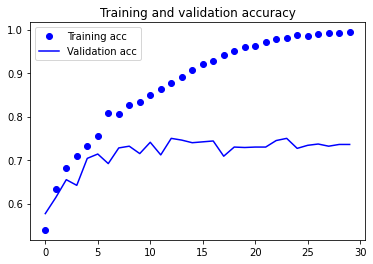

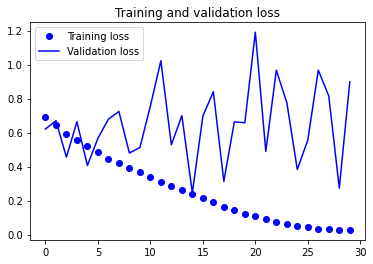

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.


<font color='red'>What is the problem here? What are possible solutions? 
The problem here is overfitting due to only having 2000 training samples. Possible solutions could be adding more training samples, weight decay or dropout, in the next section we will use data augmentation to also fix overfitting. 
</font>

## 1.4. Using data augmentation

Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. 

In Keras, this can be done by using `ImageDataGenerator`.

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#TODO: have a look at description of these parameters

These are just a few of the options available:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

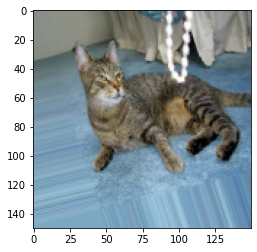

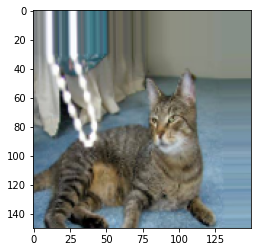

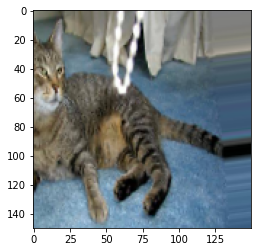

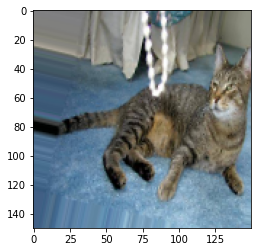

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

When using data augmentation, our network will never see twice the same input. However, the inputs 
are still heavily intercorrelated. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(512))
model.add(layers.Dense(1, activation='sigmoid'))
#TODO define the model
#layers.Dropout() could be useful, please check the document of Keras.


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 188s 2s/step - loss: 0.6966 - acc: 0.5210 - val_loss: 0.6903 - val_acc: 0.6117
Epoch 2/100
100/100 [==============================] - 185s 2s/step - loss: 0.6790 - acc: 0.5717 - val_loss: 0.7167 - val_acc: 0.6140
Epoch 3/100
100/100 [==============================] - 186s 2s/step - loss: 0.6647 - acc: 0.5914 - val_loss: 0.6491 - val_acc: 0.6352
Epoch 4/100
100/100 [==============================] - 185s 2s/step - loss: 0.6465 - acc: 0.6181 - val_loss: 0.6000 - val_acc: 0.6559
Epoch 5/100
100/100 [==============================] - 182s 2s/step - loss: 0.6319 - acc: 0.6449 - val_loss: 0.5757 - val_acc: 0.6796
Epoch 6/100
100/100 [==============================] - 190s 2s/step - loss: 0.6225 - acc: 0.6526 - val_loss: 0.7870 - val_acc: 0.6057
Epoch 7/100
100/100 [==============================] - 184s 2s/step - loss: 0.6056 - acc: 0.6648 - val_loss: 0.6

Let's save our model -- we will be using it in the section on convnet visualization.

In [0]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

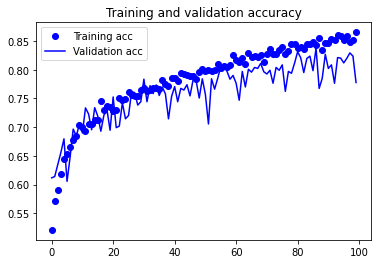

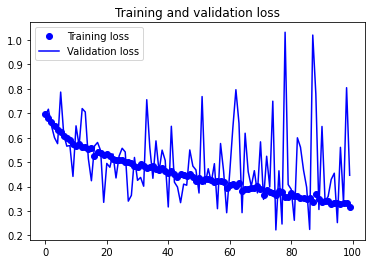

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 81-83%, a 15% relative improvement over the non-regularized model.